# Execution of Cox model

In this notebook, we test the Cox model for the data from the following article : https://doi.org/10.1158/1078-0432.CCR-20-1163.

In [9]:
import pandas as pd
import numpy as np
from survivalAnalysis.CoxModel import CoxModel
import matplotlib.pyplot as plt

## Reading and preprocessing

We read the ```data/Supplemental-table1.xlsx``` file, and we drop the non-naive patients from the dataframe.

In [10]:
df = pd.read_excel('data/Supplemental-table1.xlsx')
df = df.loc[df["Cohort"] == "Naive"]
df

,Anonymous ID,EGA ID,Tumour type,Sex,Line of therapy,Immunotherapy regimen,Cohort,Reason for discontinuation,Best response,Age at advanced disease diagnosis,...,Alive_0,Time to progression (days),Progression_1,Clinical benefit,CD8+ T cell score,Exome mut per mb,Genome mut per mb,CD274 expression,M1M2 expression,Lymph related
0,14891,EGAD00001001961,LUNG,F,8,Nivolumab,Naive,Progression,Mixed,45,...,1,179,1,NCB,0.351869,11.095310,23.0729,4.1689,55.51575,Non-lymph related
1,18624,EGAD00001002047,AECA,F,10,Nivolumab,Naive,Progression,Stable disease,47,...,1,148,1,NCB,0.071464,3.876336,5.4552,0.7910,9.32352,Non-lymph related
2,21392,EGAD00001002544,OV,F,6,Monalizumab,Naive,Progression,Physician assessed SD,57,...,1,79,1,NCB,0.040394,2.415688,4.1274,4.0377,50.12008,Lymph related
3,21516,EGAD00001002546,SKCM,F,3,Ipilimumab,Naive,Death,Not evaluable,29,...,1,11,0,NCB,0.052774,6.235845,11.4871,0.6006,1.58550,Non-lymph related
4,22186,EGAD00001001966,LUNG,F,4,Atezolizumab,Naive,Progression,Stable disease,52,...,1,80,1,NCB,0.009323,4.606660,7.1503,1.8234,38.42695,Non-lymph related
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,39280,EGAD00001004933,LUNG,M,2,Pembrolizumab,Naive,Toxicity,Physician Assessed SD,60,...,1,401,0,DCB,0.695396,84.998501,96.4079,8.4768,86.62561,Non-lymph related
94,37899,EGAD00001005838,CHOL,F,2,Nivolumab,Naive,Death,Physician assessed PR,38,...,1,96,0,NCB,0.818233,2.247151,2.7416,11.2704,47.97376,Non-lymph related
95,37775,EGAD00001004934,HNSC,M,1,Avelumab/OX40 agonist PF-04518600,Naive,Progression,Stable disease,69,...,1,69,1,NCB,0.018982,3.848247,5.8036,8.7136,5.13403,Non-lymph related
96,38313,EGAD00001005844,ACC,F,3,Avelumab/Debio1143 (SMAC mimetic),Naive,Toxicity,Partial response,34,...,1,51,1,NCB,0.000000,5.617878,7.7940,0.0688,0.51364,Non-lymph related


## Determine the risk class for each using Cox regression and survival curves

With the ```CoxModel``` class implementing a Cox Regression, we can determine the risk class for each sample : high (class 1) or low (class 0). Because we have few data, we use a **leave one out cross validation**, which consists in fitting the model with all the dataset except 1 sample, then we predict the risk class for the test sample.

In [11]:
coxmodel = CoxModel()

### TTP (Time To Progression) event
Here, the event is the disease has progressed. So we measure the risk of the disease to progress.

#### Finding risk classes

In [12]:
# Preprocessing for the label data
X_ttp = df.loc[:,["CD8+ T cell score","Exome mut per mb","Genome mut per mb","CD274 expression","M1M2 expression"]].to_numpy()
y_ttp = np.array(list((df[['Progression_1','Time to progression (days)']].itertuples(index=False, name=None))),dtype=[('Progression_1', '?'), ('Time to progression (days)', '<f8')])

# Finding the risk classes
risk_classes_ttp = coxmodel.leave_one_out_cross_validation(X_ttp,y_ttp)
risk_classes_ttp

array([0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0.,
       0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1.,
       1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
       1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1.,
       0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0.])

#### Determining the survival curves
With the Cox model, we have the survival probability for each sample along time. So we compute the mean survival curve from these curves.

In [13]:
# Split the data in high risk group and low risk group
high_risk_ttp = X_ttp[np.where(risk_classes_ttp==1)]
low_risk_ttp = X_ttp[np.where(risk_classes_ttp==0)]

# Compute the mean survival curves for each group
high_risk_event_times_ttp, high_risk_survival_curve_ttp = coxmodel.predict_mean_survival_curve(high_risk_ttp)
low_risk_event_times_ttp, low_risk_survival_curve_ttp = coxmodel.predict_mean_survival_curve(low_risk_ttp)

### OS (Overall survival) event
Here, the event is the patient has died. So we measure the risk of death.

##### Finding the risk classes

In [14]:
# Preprocessing for the label data
X_os = df.loc[:,["CD8+ T cell score","Exome mut per mb","Genome mut per mb","CD274 expression","M1M2 expression"]].to_numpy()
y_os = np.array(list((df[['Alive_0','Overall survival (days)']].itertuples(index=False, name=None))),dtype=[('Alive_0', '?'), ('Overall survival (days)', '<f8')])

# Finding the risk classes
risk_classes_os = coxmodel.leave_one_out_cross_validation(X_os,y_os)
risk_classes_os

array([0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1.,
       0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1.,
       1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
       1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1.,
       1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0.])

##### Determining the survival curves

In [15]:
# Split the data in high risk group and low risk group
high_risk_os = X_os[np.where(risk_classes_os==1)]
low_risk_os = X_os[np.where(risk_classes_os==0)]

# Compute the mean survival curves for each group
high_risk_event_times_os, high_risk_survival_curve_os = coxmodel.predict_mean_survival_curve(high_risk_os)
low_risk_event_times_os, low_risk_survival_curve_os = coxmodel.predict_mean_survival_curve(low_risk_os)

## Plot the survival curves
Now, we want to plot the survival curves for each class (high and low). Ideally, the curves should be very different.

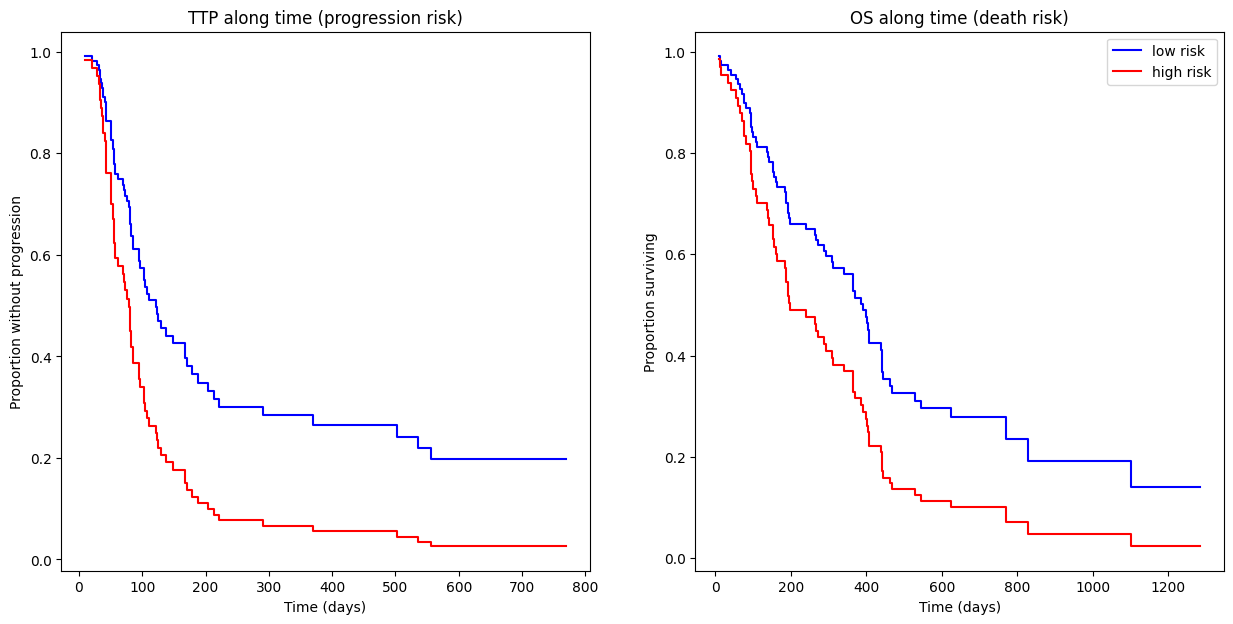

In [16]:
fig, ax = plt.subplots(1,2,figsize=(15,7))

# TTP : 
ax[0].step(low_risk_event_times_ttp, low_risk_survival_curve_ttp, where='post',color='blue',label='low risk')
ax[0].step(high_risk_event_times_ttp, high_risk_survival_curve_ttp, where='post',color='red',label='high risk')
ax[0].set_xlabel('Time (days)')
ax[0].set_ylabel('Proportion without progression')
ax[0].set_title('TTP along time (progression risk)')
#ax[0].text(0,0,f'p value : {p_value_cd274_ttp}')

# OS : 
ax[1].step(low_risk_event_times_os, low_risk_survival_curve_os, where='post',color='blue',label='low risk')
ax[1].step(high_risk_event_times_os, high_risk_survival_curve_os, where='post',color='red',label='high risk')
ax[1].set_xlabel('Time (days)')
ax[1].set_ylabel('Proportion surviving')
ax[1].set_title('OS along time (death risk)')
#ax[0].text(0,0,f'p value : {p_value_cd274_ttp}')

plt.legend()
plt.savefig('figures/survival-curves.png')